# Before running this notebook

Make sure to have enabled the environment set up for running `dimelo` analysis. See the readme for details.

# Initialization

In [1]:
from pathlib import Path

In [2]:
# Base input and output directories
test_data_dir = Path('./test/data')
output_dir = Path('./test/output')

output_dir.mkdir(exist_ok=True)

# Input files
ctcf_bam_file = test_data_dir / 'ctcf_demo.sorted.bam'
ctcf_guppy_bam_file = test_data_dir / 'winnowmap_guppy_merge_subset.updated.bam'
ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_off_target_regions = test_data_dir / 'ctcf_demo_not_peak.bed'
# TODO: WHAT DO I DO ABOUT REFERENCE GENOME????
ref_genome_file = Path('/clusterfs/nilah/oberon/genomes/chm13.draft_v1.0.fasta')

# Parsing

In [3]:
from dimelo import parse_bam

PATH does not include the conda environment /bin folder. Adding /global/home/users/dixonluinenburg/.conda/envs/dimelo_modkit_3.11/bin.
PATH is now /global/home/users/dixonluinenburg/.conda/envs/dimelo_modkit_3.11/bin:/global/software/sl-7.x86_64/modules/langs/python/3.10/bin:/global/software/sl-7.x86_64/modules/tools/sq/0.1.0/bin:/global/software/sl-7.x86_64/modules/tools/emacs/25.1/bin:/global/software/sl-7.x86_64/modules/tools/vim/7.4/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/global/home/groups/allhands/bin:/global/home/users/dixonluinenburg/bin
modkit found with expected version 0.2.4


The following cell is expected to error out, thanks to input BAM format checking.

In [4]:
pileup_file = parse_bam.pileup(
    input_file=ctcf_bam_file,
    output_name='ctcf_demo_pileup',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_files=[ctcf_target_regions],
    basemods=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

ValueError: Base modification tags are out of spec (Mm and Ml instead of MM and ML). 

Consider using "modkit update-tags test/data/ctcf_demo.sorted.bam new_file.bam" in the command line with your conda environment active and then trying with the new file. For megalodon basecalling/modcalling, you may also need to pass "--mode ambiguous.
Be sure to index the resulting .bam file."

To fix this, follow the suggestion from the error and run `modkit update-tags`...

In [5]:
!modkit update-tags \
test/data/ctcf_demo.sorted.bam \
test/output/ctcf_demo.updated.bam \
--mode ambiguous

> done, 1024 records processed, 0 failed, 0 skipped                             


In [6]:
ctcf_bam_file_updated = output_dir / 'ctcf_demo.updated.bam'

...and reindex the resulting file.

In [7]:
import pysam

pysam.index(str(ctcf_bam_file_updated))

''

Finally, the updated .bam file can be parsed, both for pileup and read extraction:

In [8]:
pileup_file = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_files=[ctcf_target_regions,ctcf_off_target_regions],
    basemods=['A,0','CG,0'],
    thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ['ctcf_demo_peak.bed', 'ctcf_demo_not_peak.bed'] using even 1000bp windows in either direction from bed region centers.
Writing new bed file regions.processed.bed
No specified number of cores requested. 32 available on machine, allocating 16
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


> parsed user-input threshold 0.74509805 for mod-code Z
> parsed user-input threshold 0.74509805 for mod-code A
> parsed user-input threshold 0.74509805 for mod-code Y
> parsed user-input threshold 0.74509805 for mod-code a
> parsed user-input threshold 0.74509805 for mod-code m
> parsing BED at test/output/ctcf_demo_pileup_on_target/regions.processed.bed
> processed 300 BED lines
> calculated chunk size: 24, interval size 100000, processing 2400000 positions concurrently
> Using filter threshold 0.74509805 for mod code Z.
> Using filter threshold 0.74509805 for mod code A.
> Using filter threshold 0.74509805 for mod code Y.
> Using filter threshold 0.74509805 for mod code a.
> Using filter threshold 0.74509805 for mod code m.
> Done, processed 123046 rows. Processed ~1012 reads and skipped zero reads.


In [9]:
# guppy_pileup_file = parse_bam.pileup(
#     input_file=ctcf_guppy_bam_file,
#     output_name='ctcf_demo_pileup_off_target',
#     ref_genome=ref_genome_file,
#     output_directory=output_dir,
#     bed_files=[ctcf_target_regions,ctcf_off_target_regions],
#     basemods=['A,0','CG,0'],
#     thresh=190,
#     window_size=1000,
#     # cores=None,
#     # cleanup=False
# )

In [ ]:
extract_file = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_files=[ctcf_target_regions,ctcf_off_target_regions],
    basemods=['A,0','CG,0'],
    thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ['ctcf_demo_peak.bed', 'ctcf_demo_not_peak.bed'] using even 1000bp windows in either direction from bed region centers.
Writing new bed file regions.processed.bed
No specified number of cores requested. 32 available on machine, allocating 16
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.
Extracting A,0 sites


# Plotting

## Plot Enrichment Profile

In [15]:
from dimelo import plot_enrichment_profile

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed
Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='fraction modified bases'>

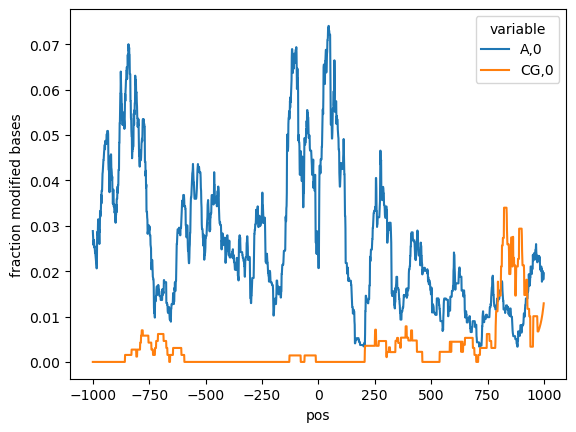

In [16]:
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file,
    bed_file_name=ctcf_target_regions,
    window_size=1000,
    mod_names=['A,0','CG,0'],
    smooth_window=50
)

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed
Loading regions from ctcf_demo_not_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_not_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='fraction modified bases'>

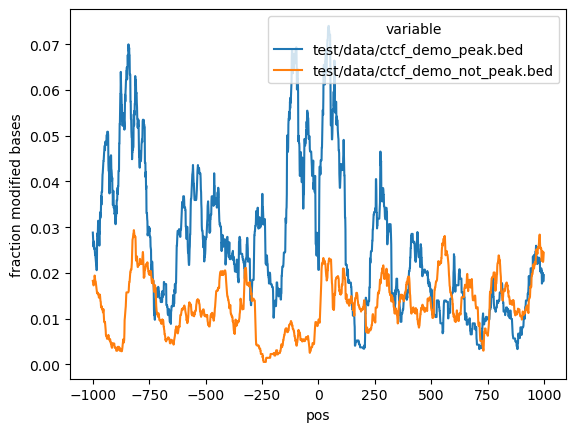

In [17]:
plot_enrichment_profile.by_regions(
    mod_file_name=pileup_file,
    bed_file_names=[ctcf_target_regions,ctcf_off_target_regions],
    window_size=1000,
    mod_name='A,0',
    smooth_window=50
)

## Plot Enrichment

In [18]:
from dimelo import plot_enrichment

<Axes: ylabel='fraction modified bases'>

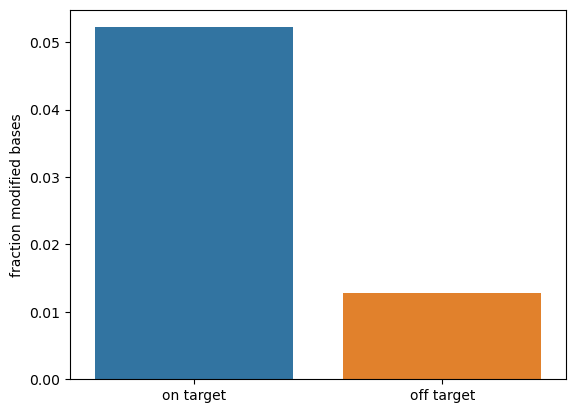

In [19]:
# TODO: When multi-bed parsing is enabled, should be changed to .by_regions
plot_enrichment.by_regions(mod_file_name=pileup_file,
                                bed_file_names=[ctcf_target_regions, ctcf_off_target_regions],
                                mod_name='A,0',
                                sample_names=['on target', 'off target'])

## Plot Reads

In [20]:
from dimelo import plot_reads

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='read_name'>

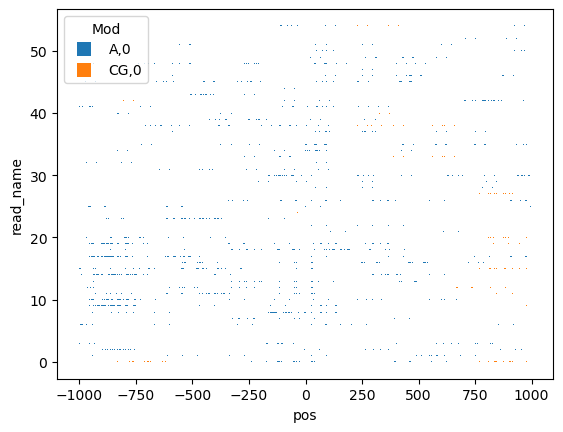

In [21]:
# TODO: This looks wrong. Why?
plot_reads.plot_reads(
    mod_file_name=extract_file,
    bed_file_name=ctcf_target_regions,
    mod_names=['A,0', 'CG,0'],
    window_size=1000
)